In [1]:
!pip install opencv-python
!pip install mahotas
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import cv2
from skimage import data, color
from skimage.filters import threshold_otsu
import mahotas
import argparse
import os
from random import randint
from random import seed
from skimage import segmentation

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 5.7 MB 9.7 MB/s 


#Class and functions used

##functions

In [2]:
def display_multi_img(images,rows,columns,F_size=(15,8),title=None,show_axis=False):
  
  fig = plt.figure(figsize=F_size)
  #fig,ax=plt.subplots(figsize=(8,10))
  for i in range(rows):
    for j in range(columns):
      fig.add_subplot(rows,columns,i*columns+j+1)
      plt.imshow(images[i][j])
      plt.axis('off')


def display_img(image,title='Image',x_label=None,y_label=None,cmap_type='gray',show_axis=False,colorBar=False,F_size=(8,6)):
  plt.figure(figsize=F_size)
  plt.imshow(image,cmap=cmap_type)
  plt.title(title)
  plt.xlabel(x_label)
  plt.ylabel(y_label)
  if colorBar: plt.colorbar()
  if not show_axis: plt.axis('off')
  plt.show()


def cut_image(image,w,h):

  (w_total,h_total,channel) = image.shape

  w_half,h_half = int(w_total/2),int(h_total/2)

  return image[w_half-w:w_half+w,h_half-h:h_half+h]

def save_image(image,image_name='Choose_my_name.jpg'):

    cv2.imwrite(image_name,image)

##Classes

In [145]:
class pre_processing:

  def __init__(self,image,to_gray = False):

    if to_gray:
      self.image = cv2.cvtColor(image.copy(), cv2.COLOR_BGR2GRAY)
    else:
      self.image = image.copy()

    self.original_image = image.copy()
    self.pipeline = dict()
  
  def color_bgr_to_gray(self):

    self.image = cv2.cvtColor(self.image, cv2.COLOR_BGR2GRAY)
  
  def gaussian_blur(self,size=(11,11)):

    if size[0]%2==0 or size[1]%2==0: raise Exception('The heigh and width must be odd');
    self.image = cv2.GaussianBlur(self.image, size, 0)
    
    self.pipeline[self.gaussian_blur.__name__] = {'size':size}

  def cut_image(self,w,h):

    (w_total,h_total) = self.image.shape

    w_half,h_half = int(w_total/2),int(h_total/2)

    self.image = self.image[w_half-w:w_half+w,h_half-h:h_half+h]

  def find_contours(self,line_thickness = 1,mode = cv2.RETR_TREE,method = cv2.CHAIN_APPROX_SIMPLE,show_contours_order = -1):

    contours, hierarchy = cv2.findContours(self.image,mode,method)
    self.contours = contours
    self.image = cv2.drawContours(self.original_image,contours,show_contours_order,(0,255,0),line_thickness)

    self.pipeline[self.find_contours.__name__] = {'line_thickness':line_thickness,'mode':mode,'method':method,'show_contours_order':show_contours_order}

  def flood_fill(self,seed_point = (20,20),new_value = 0,tolerance=100):

    self.image = segmentation.flood_fill(self.image,seed_point,new_value,tolerance=tolerance)

    self.pipeline[self.flood_fill.__name__] = {'seed_point':seed_point,'tolerance':tolerance,'new_value':new_value}

  def fixed_threshold(self,threshold=70,pixel=255,threshold_binary=False,threshold_zero=False):
    
    if threshold_zero:
      self.image = cv2.threshold(self.image, threshold, pixel, cv2.THRESH_TOZERO)[1]
    else:
      if threshold_binary:
        self.image = cv2.threshold(self.image, threshold, pixel, cv2.THRESH_BINARY)[1]
      else:  
        self.image = cv2.threshold(self.image, threshold, pixel, cv2.THRESH_BINARY_INV )[1]
      
    self.pipeline[self.fixed_threshold.__name__] = {'threshold':threshold,'pixel':pixel,'threshold_binary':threshold_binary,'threshold_zero':threshold_zero}

  def multi_threshold(self,initial_thresholds,final_thresholds,thresh_binary=True,qtd_columns=2,step=5,pixel=255):

    [matrix_of_thresholds,thresholds] = [[],initial_thresholds]

    while(True):

      row = []

      for index in range(qtd_columns):
        
        row.append(cv2.threshold(self.image, thresholds, 255, cv2.THRESH_BINARY)[1])
        row.append(cv2.threshold(self.image, thresholds, 255, cv2.THRESH_BINARY_INV)[1])
        
        thresholds+=step

      matrix_of_thresholds.append(np.hstack(row))
      if thresholds>=final_thresholds: break

    result = np.vstack(matrix_of_thresholds)
    self.display_img(result,size=(18,28))

  def adaptative_threshold(self,block_size=25,thresh_mean = True,thresh_binary_inv=True,number_to_decrease=7,pixel=255):
    
    if thresh_mean:
      if thresh_binary_inv:
        self.image = cv2.adaptiveThreshold(self.image,pixel,cv2.ADAPTIVE_THRESH_MEAN_C,cv2.THRESH_BINARY_INV,block_size,number_to_decrease)
      else:
        self.image = cv2.adaptiveThreshold(self.image,pixel,cv2.ADAPTIVE_THRESH_MEAN_C,cv2.THRESH_BINARY,block_size,number_to_decrease)
    else:
      if thresh_binary_inv:
        self.image = cv2.adaptiveThreshold(self.image,pixel,cv2.ADAPTIVE_THRESH_GAUSSIAN_C,cv2.THRESH_BINARY_INV,block_size,number_to_decrease)
      else:
        self.image = cv2.adaptiveThreshold(self.image,pixel,cv2.ADAPTIVE_THRESH_GAUSSIAN_C,cv2.THRESH_BINARY,block_size,number_to_decrease)
      
    self.pipeline[self.adaptative_threshold.__name__] = {'block_size':block_size,'thresh_mean':True,'thresh_binary_inv':True,'number_to_decrease':number_to_decrease,'pixel':pixel}

  def sobel(self,typeCV = cv2.CV_64F):

      sobelX = cv2.Sobel(self.image, typeCV, 1, 0) 
      sobelX = np.uint8(np.absolute(sobelX))
      sobelY = cv2.Sobel(self.image, typeCV, 0, 1)
      sobelY = np.uint8(np.absolute(sobelY))
      sobel = cv2.bitwise_or(sobelX, sobelY)
    
      self.image = sobel

      self.pipeline[self.sobel.__name__] = {}
  
  def laplacian_filter(self,threshold=60):

    lap = cv2.Laplacian(self.image, cv2.CV_64F) 
    lap = np.uint8(np.absolute(lap)) 
    self.image = lap

    self.pipeline[self.laplacian_filter.__name__] = {'threshold':threshold}
  
  def canny(self, T_lower=15,T_upper=120):
    
    self.image = cv2.Canny(self.image, T_lower, T_upper)
    
    self.pipeline[self.canny.__name__] = {'T_lower':T_lower,'T_upper':T_upper}

  def equalize_image(self):

    self.image = cv2.equalizeHist(self.image)

    self.pipeline[self.equalize_image.__name__] = {}

  def connectComponents(self,min_h,max_h,min_w,max_w):

    output = cv2.connectedComponentsWithStats(self.image, 4, cv2.CV_32S)

    (numLabels, labels, stats, centroids) = output
    [matrix_of_slice,matrix_of_result,matrix_of_mask] = [[],[],[]]

    for i in range(0,numLabels):
      
      if i is not 0:
        
        print('infor examining component {}/{}'.format(i,numLabels-1))
        x = stats[i,cv2.CC_STAT_LEFT]
        y = stats[i,cv2.CC_STAT_TOP]
        w = stats[i,cv2.CC_STAT_WIDTH]
        h = stats[i,cv2.CC_STAT_HEIGHT]
        area = stats[i,cv2.CC_STAT_AREA]
        (cX,cY) = centroids[i]
        result = self.original_image.copy()
  
        image_slice = result[x:x + w + 5,y:y + h+ 5]

        keepWidth = w > min_w and w < max_w
        keepHeight = h > min_h and h < max_h
  
        if all((keepWidth, keepHeight)):
          
          print('selected')
          matrix_of_slice.append(image_slice)
          matrix_of_result.append(result)
          cv2.rectangle(result, (x, y), (x + w, y + h), (0, 255, 0), 3)
          cv2.circle(result, (int(cX), int(cY)), 4, (0, 0, 255), -1)
          componentMask = (labels == i).astype("uint8") * 255
      
    return [matrix_of_slice,matrix_of_result],len(matrix_of_result)

  def get_image(self):

    return self.image
  
  def save_image(self,image_name='Choose_my_name.jpg'):

    cv2.imwrite(image_name,self.image)

  def display_img(self,title='Image',x_label=None,y_label=None,cmap_type='gray',show_axis=False,colorBar=False,size=(8,6)):
    plt.figure(figsize=size)
    plt.imshow(self.image,cmap=cmap_type)
    plt.title(title)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    if colorBar: plt.colorbar()
    if not show_axis: plt.axis('off')
    plt.show()



#Loading data

#Loading all nodule images

All data are loaded from Google Drive. However, if you choose to select some of them randomly, you may get an error once there are a few images of different sizes. 

Number of maligno images: 262
Number of benigno images: 275
Number of maligno images with size 200x200: 242
Number of benigno images with size 200x200: 241
65 12 174 85
(200, 200, 3) (200, 200, 3) (200, 200, 3) (200, 200, 3)


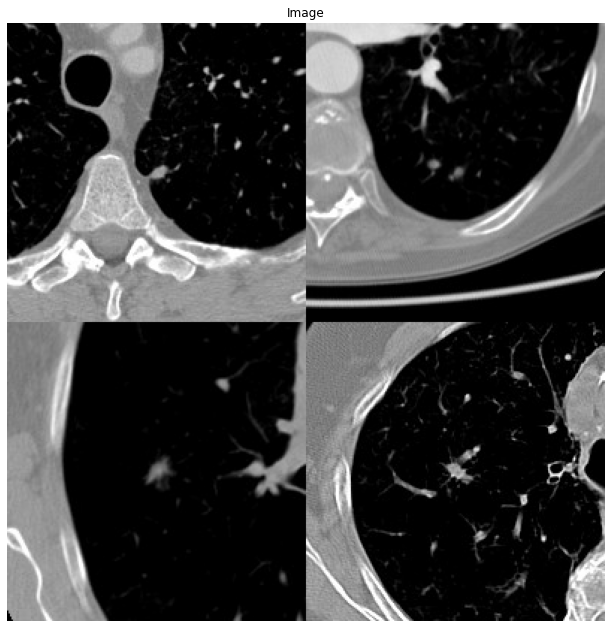

In [94]:
select_images_randomly = True

directory_path_malignos = '/content/drive/MyDrive/all_nods_malignos_converted/'
directory_path_benignos = '/content/drive/MyDrive/all_nods_benignos_converted/'

directory_files = os.listdir(directory_path_malignos)
array_of_images_malignos = [plt.imread( os.path.join(directory_path_malignos,file) ) for file in directory_files]
array_of_images_malignos_200 = [plt.imread( os.path.join(directory_path_malignos,file) ) for file in directory_files if plt.imread(os.path.join(directory_path_malignos,file)).shape[0] == 200 and plt.imread(os.path.join(directory_path_malignos,file)).shape[1] == 200]

directory_files = os.listdir(directory_path_benignos)
array_of_images_benignos = [plt.imread( os.path.join(directory_path_benignos,file) ) for file in directory_files]
array_of_images_benignos_200 = [plt.imread( os.path.join(directory_path_benignos,file) ) for file in directory_files if plt.imread( os.path.join(directory_path_benignos,file) ).shape[0] == 200 and plt.imread( os.path.join(directory_path_benignos,file) ).shape[1] == 200]

print(f'Number of maligno images: {len(array_of_images_malignos)}')
print(f'Number of benigno images: {len(array_of_images_benignos)}')
print(f'Number of maligno images with size 200x200: {len(array_of_images_malignos_200)}')
print(f'Number of benigno images with size 200x200: {len(array_of_images_benignos_200)}')

if select_images_randomly:

  index_benigno1,index_benigno2 = randint(0,len(array_of_images_benignos_200)-1),randint(0,len(array_of_images_benignos_200)-1)
  index_maligno1,index_maligno2 = randint(0,len(array_of_images_malignos_200)-1),randint(0,len(array_of_images_malignos_200)-1)
  print(index_benigno1,index_benigno2,index_maligno1,index_maligno2)
  [benigno1,benigno2] = [array_of_images_benignos_200[index_benigno1],array_of_images_benignos_200[index_benigno2]]
  [maligno1,maligno2] = [array_of_images_malignos_200[index_maligno1],array_of_images_malignos_200[index_maligno2]]

else:

  index_benigno1,index_benigno2 = 2,3
  index_maligno1,index_maligno2 = 10,16
  [benigno1,benigno2] = [array_of_images_benignos[index_benigno1],array_of_images_benignos[index_benigno2]]
  [maligno1,maligno2] = [array_of_images_malignos[index_maligno1],array_of_images_malignos[index_maligno2]]

print(benigno1.shape,benigno2.shape,maligno1.shape,maligno2.shape)

four_images = np.vstack([  np.hstack([benigno1, benigno2]),  np.hstack([maligno1, maligno2])  ])
display_img(four_images,F_size=(11,11))

tumor_picture = four_images

##Getting all cropped images

(44, 44, 3) (44, 44, 3) (44, 44, 3) (44, 44, 3)


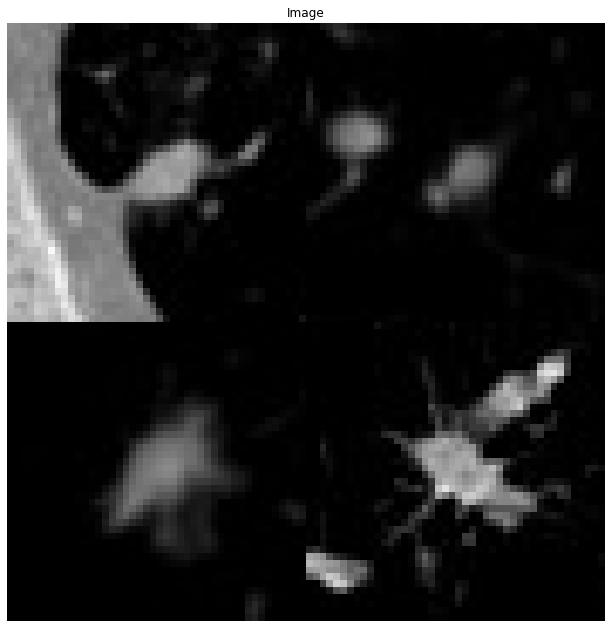

In [95]:
[cropped_benigno_images,cropped_maligno_images] = [[],[]]

if select_images_randomly:
  cropped_benigno_images = [cut_image(image,22,22) for image in array_of_images_benignos_200]
  cropped_maligno_images = [cut_image(image,22,22) for image in array_of_images_malignos_200]
else:
  cropped_benigno_images = [cut_image(image,22,22) for image in array_of_images_benignos]
  cropped_maligno_images = [cut_image(image,22,22) for image in array_of_images_malignos]

[benigno1,benigno2] = [cropped_benigno_images[index_benigno1],cropped_benigno_images[index_benigno2]]
[maligno1,maligno2] = [cropped_maligno_images[index_maligno1],cropped_maligno_images[index_maligno2]]

print(benigno1.shape,benigno2.shape,maligno1.shape,maligno2.shape)

four_images = np.vstack([  np.hstack([benigno1, benigno2]),  np.hstack([maligno1, maligno2])  ])
display_img(four_images,F_size=(11,11))

tumor_picture = four_images

#Pipelines

## threshold

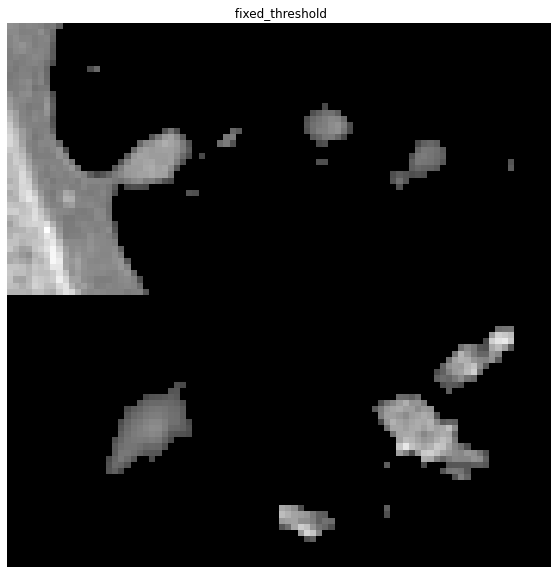

{'fixed_threshold': {'threshold': 70, 'pixel': 255, 'threshold_binary': False, 'threshold_zero': True}}


In [96]:
title = ''

pipeline1 = pre_processing(tumor_picture,to_gray=True)
pipeline1.fixed_threshold(70,threshold_binary=False,threshold_zero=True)

for name in pipeline1.pipeline.keys():title += ' '+name

pipeline1.display_img(title=title,size=(10,10))
#pipeline1.save_image(title+'.png')
print(pipeline1.pipeline)


##Blur + Fixed Threshold + Sobel

Explanation: In this pipeline, I was trying to figure out a way to highlight the nodule border, remove image noises and increase the difference between that border and the image remaining. As you can see below, all the border was really emphasized and noises removed, making it easier to detect the nodules.

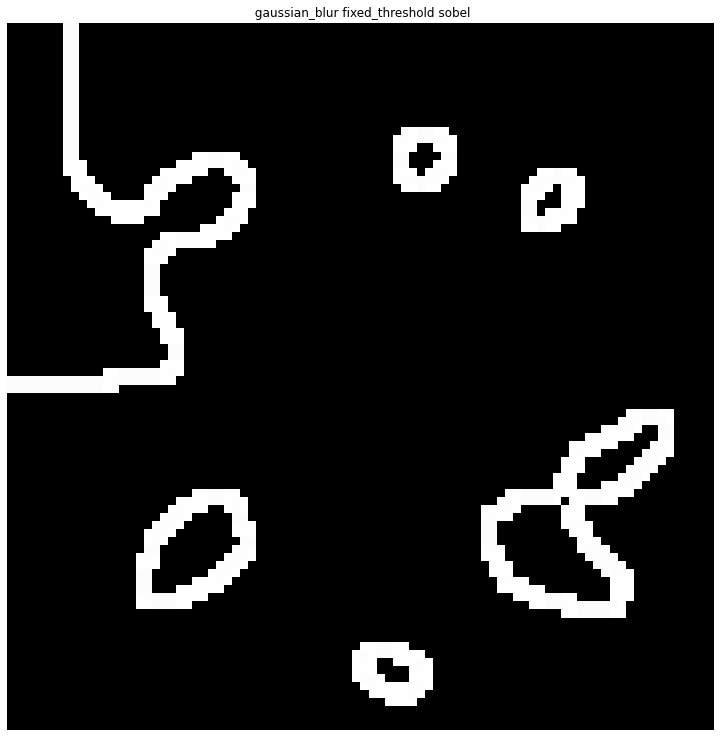

{'gaussian_blur': {'size': (11, 11)}, 'fixed_threshold': {'threshold': 60, 'pixel': 255, 'threshold_binary': False, 'threshold_zero': False}, 'sobel': {}}


In [97]:
title = ''
pipeline2 = pre_processing(tumor_picture,to_gray=True)
pipeline2.gaussian_blur((11,11))
pipeline2.fixed_threshold(60)
pipeline2.sobel()

for name in pipeline2.pipeline.keys(): title += ' '+name

pipeline2.display_img(title=title,size=(13,13))
pipeline2.save_image(title+'.png')
print(pipeline2.pipeline)

##Equalize image

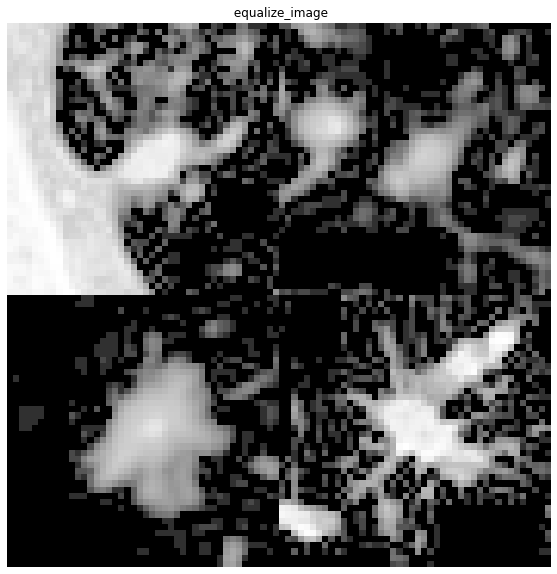

{'equalize_image': {}}


In [98]:
title = ''

pipelineEqualize = pre_processing(tumor_picture,to_gray=True)
pipelineEqualize.equalize_image()

for name in pipelineEqualize.pipeline.keys():title += ' '+name
pipelineEqualize.display_img(title=title,size=(10,10))

#pipelineEqualize.save_image(title+'.png')
print(pipelineEqualize.pipeline)


##Fixed Threshold + Laplacian Filter




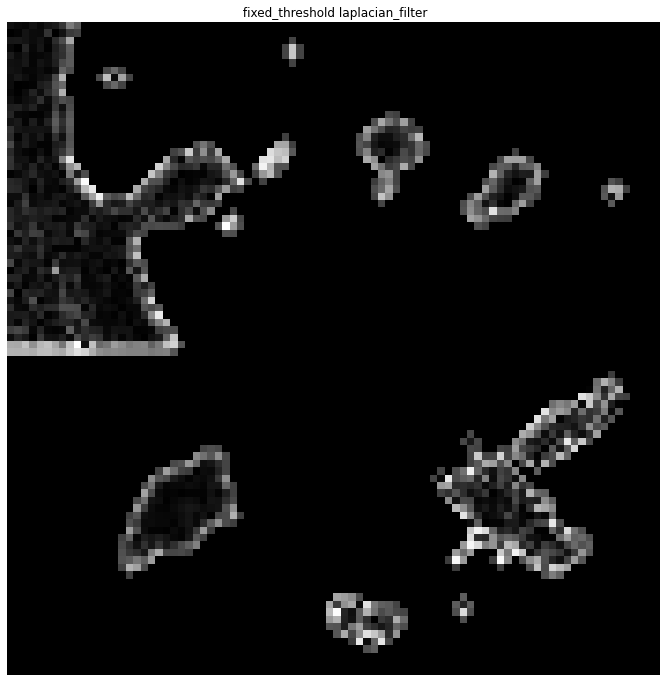

{'fixed_threshold': {'threshold': 60, 'pixel': 255, 'threshold_binary': False, 'threshold_zero': True}, 'laplacian_filter': {'threshold': 60}}


In [99]:
title = ''
pipeline3 = pre_processing(tumor_picture,to_gray=True)
pipeline3.fixed_threshold(60,threshold_binary=False,threshold_zero=True)
pipeline3.laplacian_filter()
#pipeline3.sobel()

for name in pipeline3.pipeline.keys(): title += ' '+name

pipeline3.display_img(title=title,size=(12,12))
pipeline3.save_image(title+'.png')
print(pipeline3.pipeline)

##Fixed Threshold + Blur + Sobel

Explanation: Here, I highlighted the nodules once some of them are more transparent and less visible. The noises were removed too. The images bellow show clearer borders than the other pipelines. You can change the threshold to achieve better outcomes.

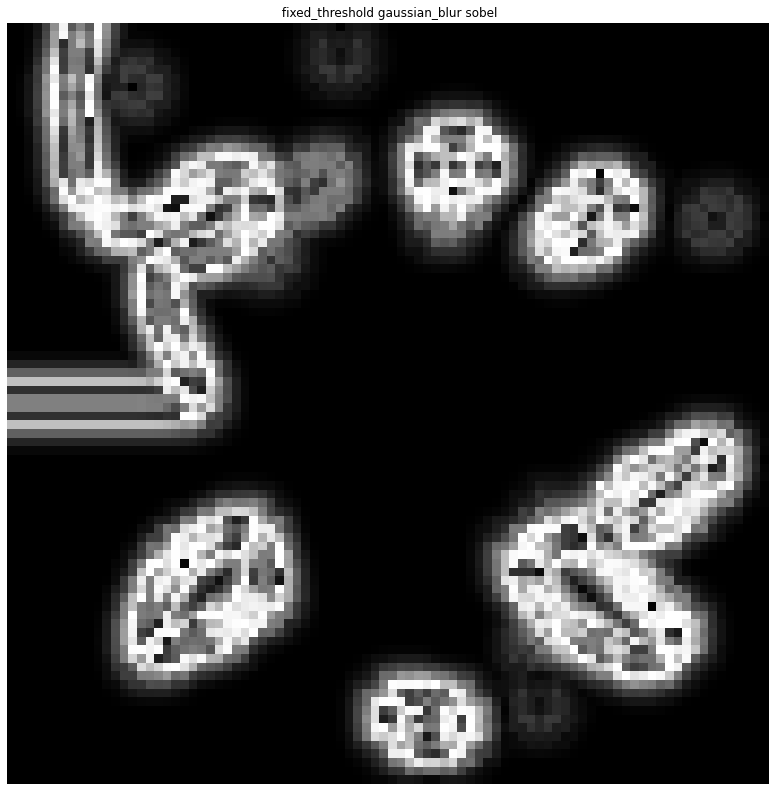

In [100]:
title = ''
pipeline4 = pre_processing(tumor_picture,to_gray=True)
pipeline4.fixed_threshold(60)
pipeline4.gaussian_blur()
pipeline4.sobel()

for name in pipeline4.pipeline.keys():title += ' '+name
pipeline4.display_img(title=title, size=(14,14))
pipeline4.save_image(title+'.png')

matrix = pipeline4.get_image()

##Blur + Canny

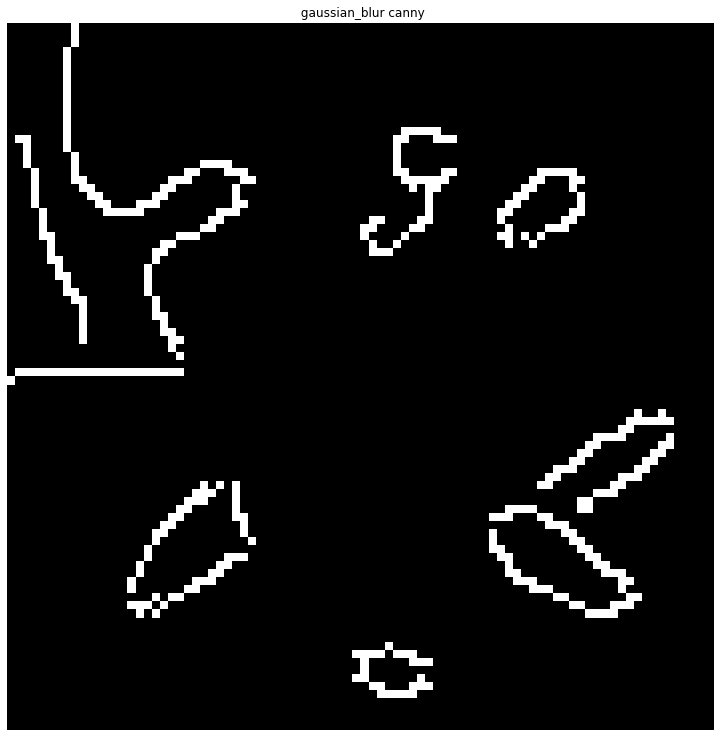

{'gaussian_blur': {'size': (11, 11)}, 'canny': {'T_lower': 15, 'T_upper': 150}}


In [101]:
title = ''

pipeline6 = pre_processing(tumor_picture,to_gray=True)
pipeline6.gaussian_blur()
pipeline6.canny(15,150)

for name in pipeline6.pipeline.keys():title += ' '+name
pipeline6.display_img(title=title,size=(13,13))
#pipeline6.save_image(title+'.png')

print(pipeline6.pipeline)

## Flood fill

###Applying flood fill in the 4 images selected

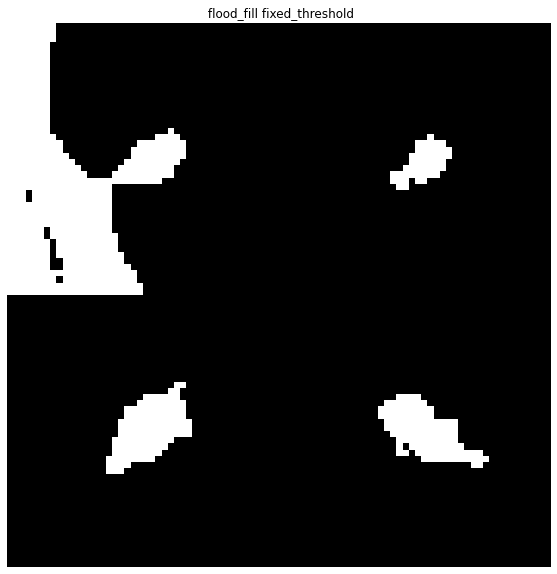

{'flood_fill': {'seed_point': (22, 66), 'tolerance': 60, 'new_value': 255}, 'fixed_threshold': {'threshold': 250, 'pixel': 255, 'threshold_binary': False, 'threshold_zero': True}}


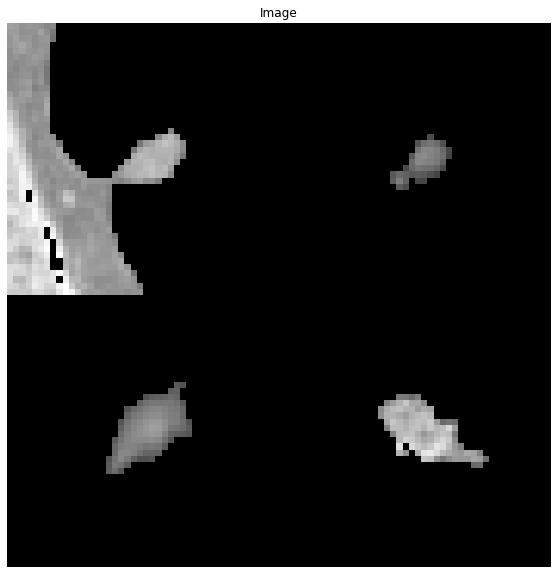

In [153]:
title = ''

pipeline6 = pre_processing(tumor_picture,to_gray=True)
pipeline6.flood_fill((int(tumor_picture.shape[0]*3/4),int(tumor_picture.shape[1]*3/4)),255,tolerance=60)
pipeline6.flood_fill((int(tumor_picture.shape[0]*1/4),int(tumor_picture.shape[1]*1/4)),255,tolerance=60)
pipeline6.flood_fill((int(tumor_picture.shape[0]*3/4),int(tumor_picture.shape[1]*1/4)),255,tolerance=60)
pipeline6.flood_fill((int(tumor_picture.shape[0]*1/4),int(tumor_picture.shape[1]*3/4)),255,tolerance=60)

pipeline6.fixed_threshold(250,threshold_zero=True)

for name in pipeline6.pipeline.keys():title += ' '+name
pipeline6.display_img(title=title,size=(10,10))

print(pipeline6.pipeline)

new_image = []

for i,key_i in enumerate(pipeline6.image):

  new_image.append([pipeline6.original_image[i][j][0] if key_j > 251 else pipeline6.image[i][j] for j,key_j in enumerate(pipeline6.image[i])])

display_img(new_image,F_size=(10,10))

###Applying flood fill in an image

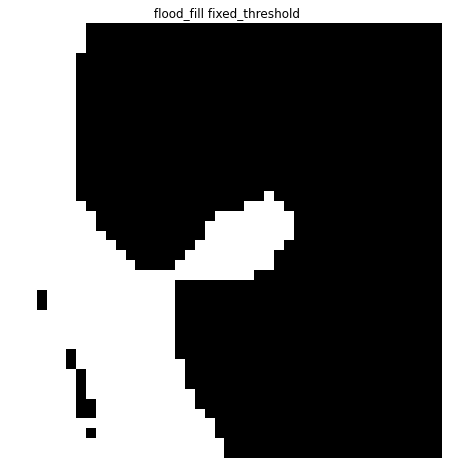

{'flood_fill': {'seed_point': (22, 22), 'tolerance': 60, 'new_value': 255}, 'fixed_threshold': {'threshold': 250, 'pixel': 255, 'threshold_binary': False, 'threshold_zero': True}}


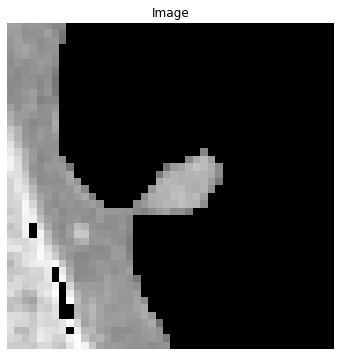

In [107]:
title = ''

pipeline6 = pre_processing(benigno1,to_gray=True)
pipeline6.flood_fill((int(benigno1.shape[0]/2),int(benigno1.shape[1]/2)),255,tolerance=60)

pipeline6.fixed_threshold(250,threshold_zero=True)

for name in pipeline6.pipeline.keys():title += ' '+name
pipeline6.display_img(title=title,size=(8,8))

print(pipeline6.pipeline)

new_image = []

for i,key_i in enumerate(pipeline6.image):

  new_image.append([pipeline6.original_image[i][j][0] if key_j > 251 else pipeline6.image[i][j] for j,key_j in enumerate(pipeline6.image[i])])

display_img(new_image)


#morphological operations and contours

###morphological operations

I still need to create a method in my class to add that algorithm.

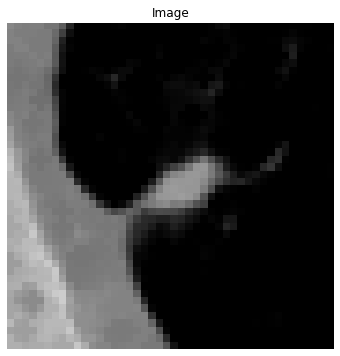

In [110]:
result = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(3,3))
image = cv2.erode(benigno1,result,iterations=1)
display_img(image)

###Find contours

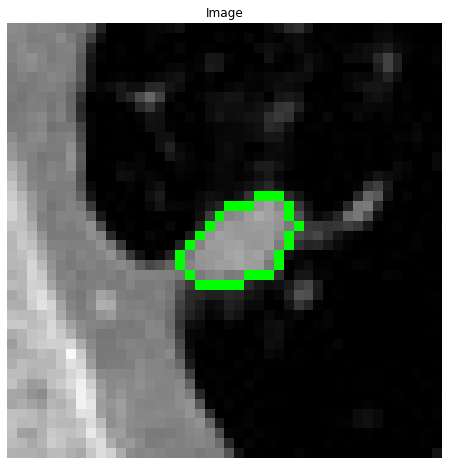

{'fixed_threshold': {'threshold': 120, 'pixel': 255, 'threshold_binary': False, 'threshold_zero': False}, 'find_contours': {'line_thickness': 1, 'mode': 3, 'method': 2, 'show_contours_order': 11}}


In [161]:
pipeline7 = pre_processing(benigno1,to_gray=True)
pipeline7.fixed_threshold(120)
pipeline7.find_contours(show_contours_order=11) # 11 in that case
pipeline7.display_img(size=(8,8))

print(pipeline7.pipeline)

#Creating new dataset based on the filters used above

In [ ]:
paths = ['/content/drive/MyDrive/cropped_nods_benigno/','/content/drive/MyDrive/cropped_nods_maligno/','/content/drive/MyDrive/cropped_nods_200_benigno/','/content/drive/MyDrive/cropped_nods_200_maligno/']
arrays = [array_of_images_benignos,array_of_images_malignos,array_of_images_benignos_200,array_of_images_malignos_200]

for i in range(len(paths)):
  count=0
  os.chdir(paths[i])
  cropped_images = [cut_image(image,20,20) for image in arrays[i]]
  for image in cropped_images:
    save_image(image,image_name=str(count)+'.jpg')
    count+=1



#cropped_maligno_images_path =
#cropped_benigno_200_images_path =
#cropped_maligno_200_images_path =
